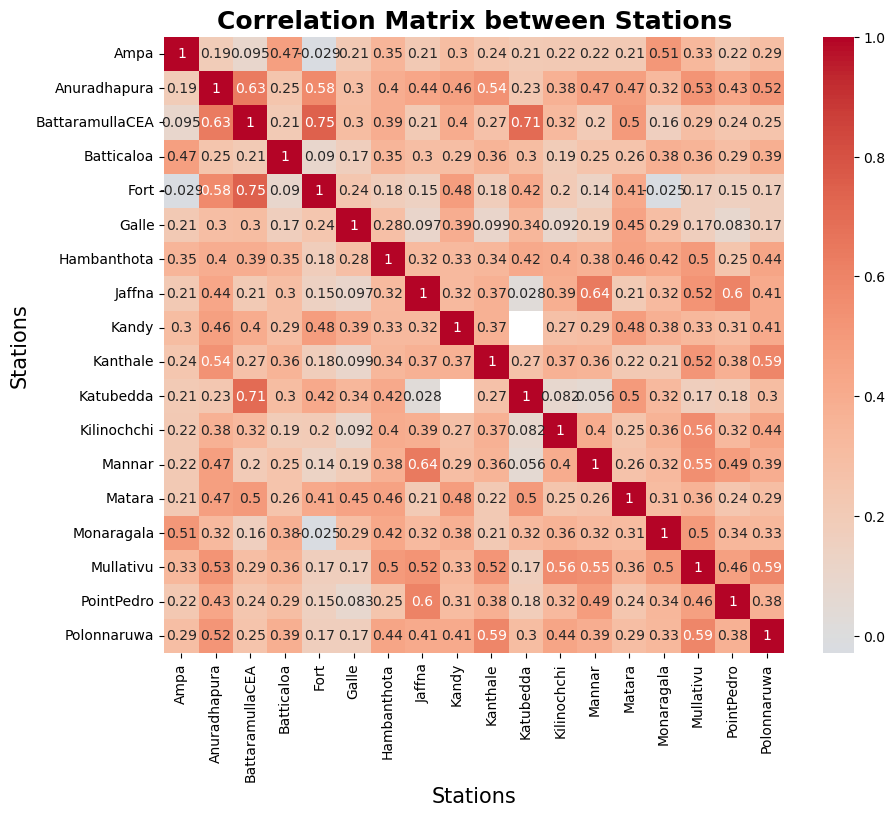

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the data
file_paths = [f'D:/7th Semi/Project/dataset/Processed/{file}' for file in os.listdir('D:/7th Semi/Project/dataset/Processed') if file.endswith('.csv')]

station_data = []
station_names = []  # To store the names of the files (stations)

for file in file_paths:
    df = pd.read_csv(file, index_col='timestamp_index', parse_dates=True)
    station_data.append(df['PM2.5 (ug/m3)'])  # Assuming 'pm2.5' column for each station's data
    station_names.append(os.path.splitext(os.path.basename(file))[0])  # Get file name without extension

# Step 2: Combine all station data into one DataFrame
pm25_data = pd.concat(station_data, axis=1)
pm25_data.columns = station_names  # Set column names as station file names

# Step 3: Calculate the correlation matrix
correlation_matrix = pm25_data.corr()

# Step 4: Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=station_names, yticklabels=station_names, center=0)
plt.title("Correlation Matrix between Stations", fontsize=18, weight='bold')
plt.xlabel("Stations", fontsize=15)
plt.ylabel("Stations", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


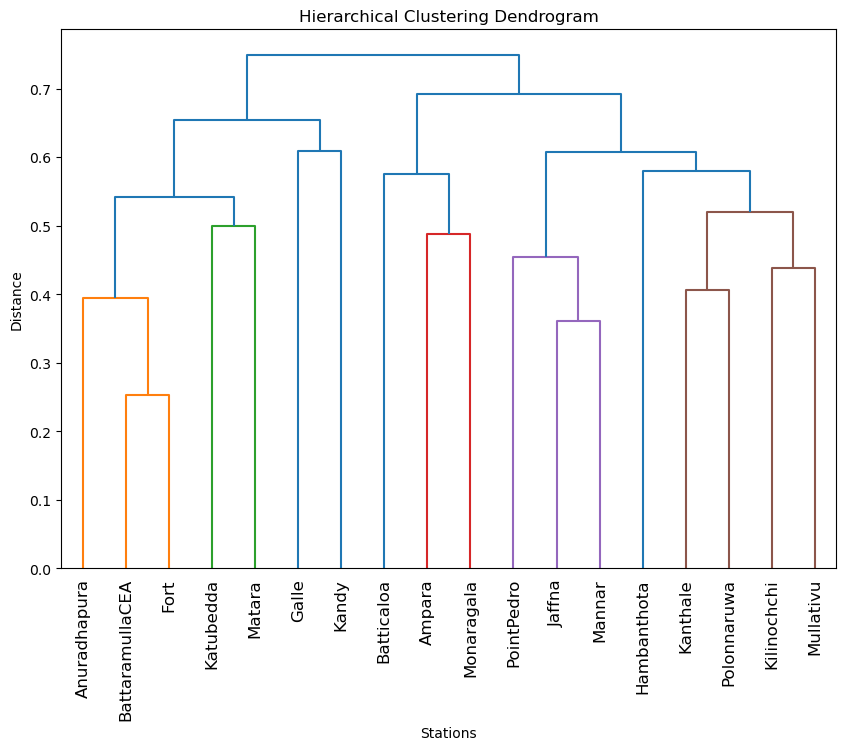

Cluster 0:
['Anuradhapura', 'Hambanthota', 'Jaffna', 'Kanthale', 'Kilinochchi', 'Mannar', 'Mullativu', 'PointPedro', 'Polonnaruwa']
Cluster 1:
['BattaramullaCEA', 'Fort', 'Galle', 'Kandy', 'Katubedda', 'Matara']
Cluster 2:
['Ampara', 'Batticaloa', 'Monaragala']


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import warnings

# Resolve the memory leak warning on Windows by limiting threads
os.environ["OMP_NUM_THREADS"] = "1"

# Suppress specific warnings if needed
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

# Step 1: Load the data
file_paths = [f'D:/7th Semi/Project/dataset/Processed/{file}' for file in os.listdir('D:/7th Semi/Project/dataset/Processed') if file.endswith('.csv')]

station_data = []
station_names = []  # To store the names of the files (stations)

for file in file_paths:
    df = pd.read_csv(file, index_col='timestamp_index', parse_dates=True)
    station_data.append(df['PM2.5 (ug/m3)'])  # Assuming 'pm2.5' column for each station's data
    station_names.append(os.path.splitext(os.path.basename(file))[0])  # Get file name without extension

# Step 2: Combine all station data into one DataFrame
pm25_data = pd.concat(station_data, axis=1)
pm25_data.columns = station_names  # Set column names as station file names

# Step 3: Calculate the correlation matrix
correlation_matrix = pm25_data.corr()

# Step 4: Handle NaN or infinite values in the correlation matrix
# Check for NaN or infinite values
if correlation_matrix.isnull().values.any() or np.isinf(correlation_matrix.values).any():
    print("Warning: Correlation matrix contains NaN or infinite values. Replacing with 0.")
    # Replace NaN or infinite values with 0 (or any other value you prefer, like the mean)
    correlation_matrix = correlation_matrix.fillna(0)
    correlation_matrix = correlation_matrix.replace([np.inf, -np.inf], 0)

# Step 5: Convert correlation to distance (1 - correlation)
distance_matrix = 1 - correlation_matrix

# Step 6: Perform Hierarchical Clustering (or KMeans)
# Convert the distance matrix to a NumPy array for validity check
distance_matrix_np = distance_matrix.to_numpy()

# Ensure the distance matrix is valid (i.e., all values are finite)
if np.isfinite(distance_matrix_np).all():
    linkage_matrix = linkage(squareform(distance_matrix_np, checks=False), method='average')
else:
    raise ValueError("The distance matrix contains invalid (non-finite) values.")

# Step 7: Plot a dendrogram (for hierarchical clustering)
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=pm25_data.columns.tolist(), orientation='top')

# Rotate the labels to make them vertical and avoid overlap
plt.xticks(rotation=90)

plt.title("Hierarchical Clustering Dendrogram", fontsize=18, weight='bold')
plt.xlabel("Stations")
plt.ylabel("Distance")
plt.show()

# Step 8: Use KMeans to assign clusters based on the correlation matrix (stations only)
kmeans = KMeans(n_clusters=3)
kmeans.fit(correlation_matrix)  # Fit clustering on the correlation matrix (stations)
station_clusters = kmeans.labels_  # Get the cluster labels for each station

# Step 9: Create a DataFrame for the station clusters
station_cluster_df = pd.DataFrame({
    'Station': pm25_data.columns,
    'Cluster': station_clusters
})

# Display the clusters with file names (station names)
for cluster_id in np.unique(station_clusters):
    print(f"Cluster {cluster_id}:")
    cluster_stations = station_cluster_df[station_cluster_df['Cluster'] == cluster_id]['Station']
    print(cluster_stations.tolist())

# Optionally, you can assign the cluster labels to the original pm25_data DataFrame
# to track the clusters for each station if needed


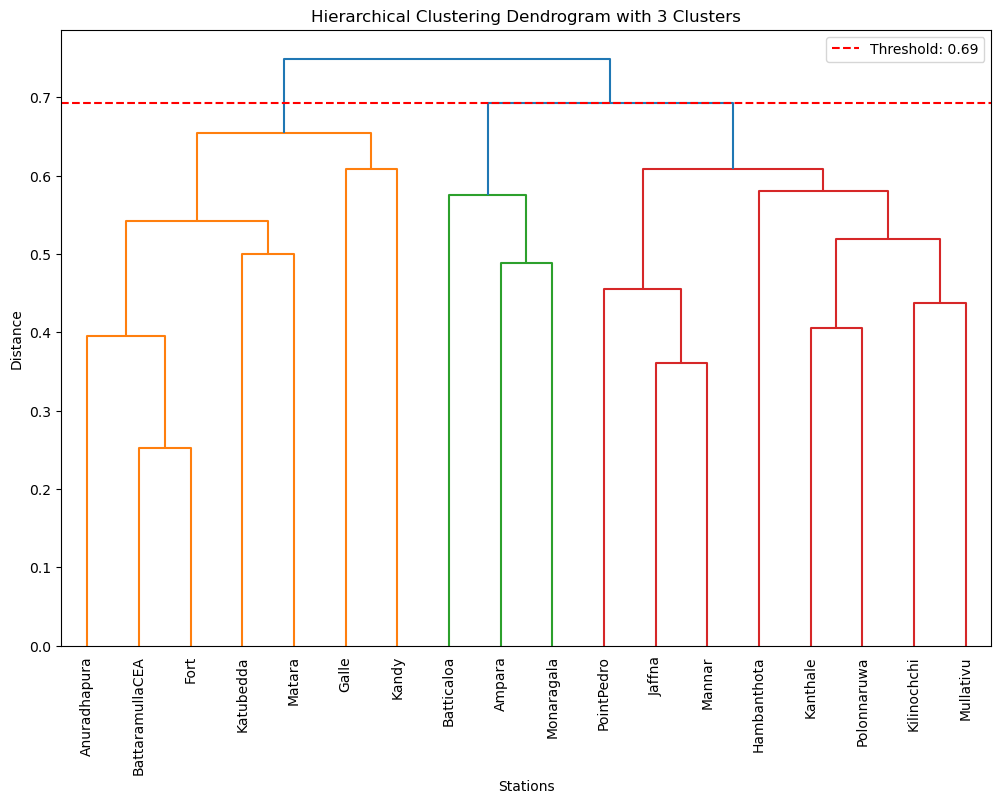

Cluster 1:
['Anuradhapura', 'BattaramullaCEA', 'Fort', 'Galle', 'Kandy', 'Katubedda', 'Matara']
Cluster 2:
['Ampara', 'Batticaloa', 'Monaragala']
Cluster 3:
['Hambanthota', 'Jaffna', 'Kanthale', 'Kilinochchi', 'Mannar', 'Mullativu', 'PointPedro', 'Polonnaruwa']


In [13]:
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Step 1: Load the data
file_paths = [f'D:/7th Semi/Project/dataset/Processed/{file}' for file in os.listdir('D:/7th Semi/Project/dataset/Processed') if file.endswith('.csv')]

station_data = []
station_names = []  # To store the names of the files (stations)

for file in file_paths:
    df = pd.read_csv(file, index_col='timestamp_index', parse_dates=True)
    station_data.append(df['PM2.5 (ug/m3)'])  # Assuming 'PM2.5 (ug/m3)' column for each station's data
    station_names.append(os.path.splitext(os.path.basename(file))[0])  # Get file name without extension

# Step 2: Combine all station data into one DataFrame
pm25_data = pd.concat(station_data, axis=1)
pm25_data.columns = station_names  # Set column names as station file names

# Step 3: Calculate the correlation matrix
correlation_matrix = pm25_data.corr()

# Step 4: Handle NaN or infinite values in the correlation matrix
if correlation_matrix.isnull().values.any() or np.isinf(correlation_matrix.values).any():
    correlation_matrix = correlation_matrix.fillna(0)
    correlation_matrix = correlation_matrix.replace([np.inf, -np.inf], 0)

# Step 5: Convert correlation to distance (1 - correlation)
distance_matrix = 1 - correlation_matrix

# Step 6: Perform Hierarchical Clustering
linkage_matrix = linkage(squareform(distance_matrix, checks=False), method='average')

# Step 7: Assign clusters into exactly 3 groups
num_clusters = 3
clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Determine the color threshold for exactly 3 clusters
max_distance = linkage_matrix[-(num_clusters - 1), 2]

# Step 8: Plot a dendrogram with 3 clusters
plt.figure(figsize=(12, 8))

# Create the dendrogram with a color threshold
dendrogram(
    linkage_matrix,
    labels=pm25_data.columns.tolist(),
    orientation='top',
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=max_distance,  # Set the color threshold to split into 3 clusters
)

# Add title and labels
plt.title("Hierarchical Clustering Dendrogram with 3 Clusters")
plt.xlabel("Stations",fontsize=15)
plt.ylabel("Distance",fontsize=15)
plt.axhline(y=max_distance, color='r', linestyle='--', label=f"Threshold: {max_distance:.2f}")  # Optional: Visualize the threshold
plt.legend()
plt.show()

# Step 9: Display the stations in each cluster
cluster_df = pd.DataFrame({
    'Station': pm25_data.columns,
    'Cluster': clusters
})

for cluster_id in range(1, num_clusters + 1):
    print(f"Cluster {cluster_id}:")
    cluster_stations = cluster_df[cluster_df['Cluster'] == cluster_id]['Station']
    print(cluster_stations.tolist())

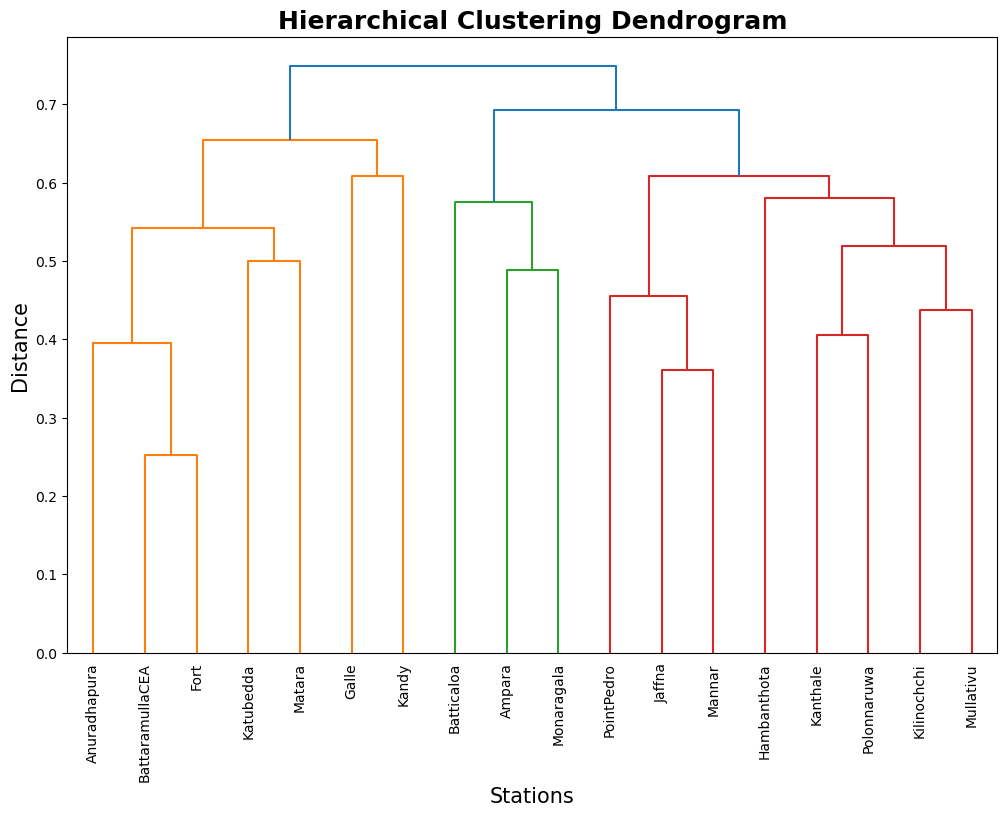

Cluster 1:
['Anuradhapura', 'BattaramullaCEA', 'Fort', 'Galle', 'Kandy', 'Katubedda', 'Matara']
Cluster 2:
['Ampara', 'Batticaloa', 'Monaragala']
Cluster 3:
['Hambanthota', 'Jaffna', 'Kanthale', 'Kilinochchi', 'Mannar', 'Mullativu', 'PointPedro', 'Polonnaruwa']


In [15]:
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Step 1: Load the data
file_paths = [f'D:/7th Semi/Project/dataset/Processed/{file}' for file in os.listdir('D:/7th Semi/Project/dataset/Processed') if file.endswith('.csv')]

station_data = []
station_names = []  # To store the names of the files (stations)

for file in file_paths:
    df = pd.read_csv(file, index_col='timestamp_index', parse_dates=True)
    station_data.append(df['PM2.5 (ug/m3)'])  # Assuming 'PM2.5 (ug/m3)' column for each station's data
    station_names.append(os.path.splitext(os.path.basename(file))[0])  # Get file name without extension

# Step 2: Combine all station data into one DataFrame
pm25_data = pd.concat(station_data, axis=1)
pm25_data.columns = station_names  # Set column names as station file names

# Step 3: Calculate the correlation matrix
correlation_matrix = pm25_data.corr()

# Step 4: Handle NaN or infinite values in the correlation matrix
if correlation_matrix.isnull().values.any() or np.isinf(correlation_matrix.values).any():
    correlation_matrix = correlation_matrix.fillna(0)
    correlation_matrix = correlation_matrix.replace([np.inf, -np.inf], 0)

# Step 5: Convert correlation to distance (1 - correlation)
distance_matrix = 1 - correlation_matrix

# Step 6: Perform Hierarchical Clustering
linkage_matrix = linkage(squareform(distance_matrix, checks=False), method='average')

# Step 7: Assign clusters into exactly 3 groups
num_clusters = 3
clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Determine the color threshold for exactly 3 clusters
max_distance = linkage_matrix[-(num_clusters - 1), 2]

# Step 8: Plot a dendrogram with 3 clusters (without threshold line)
plt.figure(figsize=(12, 8))

# Create the dendrogram with a color threshold
dendrogram(
    linkage_matrix,
    labels=pm25_data.columns.tolist(),
    orientation='top',
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=max_distance,  # Set the color threshold to split into 3 clusters
)

# Add title and labels
plt.title("Hierarchical Clustering Dendrogram",fontsize=18, weight='bold')
plt.xlabel("Stations",fontsize=15)
plt.ylabel("Distance",fontsize=15)
plt.show()

# Step 9: Display the stations in each cluster
cluster_df = pd.DataFrame({
    'Station': pm25_data.columns,
    'Cluster': clusters
})

for cluster_id in range(1, num_clusters + 1):
    print(f"Cluster {cluster_id}:")
    cluster_stations = cluster_df[cluster_df['Cluster'] == cluster_id]['Station']
    print(cluster_stations.tolist())